In [205]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [206]:
# Load the dataset
data = pd.read_csv(r'D:\ML Repositories\Price_forecasting_project\data\raw\processed\Delicious_A_dataset.csv')

In [207]:
data

,Date,District,Market,Fruit,Variety,Grade,Min Price (per kg),Max Price (per kg),Avg Price (per kg),Mask
0,2017-09-01,NaN,NaN,NaN,Delicious,A,0.0,0.0,0.00,0
1,2017-09-02,NaN,NaN,NaN,Delicious,A,0.0,0.0,0.00,0
2,2017-09-03,NaN,NaN,NaN,Delicious,A,0.0,0.0,0.00,0
3,2017-09-04,NaN,NaN,NaN,Delicious,A,0.0,0.0,0.00,0
4,2017-09-05,NaN,NaN,NaN,Delicious,A,0.0,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...
2674,2024-12-27,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1
2675,2024-12-28,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1
2676,2024-12-29,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1
2677,2024-12-30,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1


In [208]:
data.columns

Index(['Date', 'District', 'Market', 'Fruit', 'Variety', 'Grade',
       'Min Price (per kg)', 'Max Price (per kg)', 'Avg Price (per kg)',
       'Mask'],
      dtype='object')

In [209]:
# Ensure proper datetime format for models requiring 'ds'
data = data.rename(columns={"Date": "ds", "Avg Price (per kg)": "y"})
data['ds'] = pd.to_datetime(data['ds'])

In [210]:
# Filter for available data (Mask=1) for SARIMA and Prophet
available_data = data[data['Mask'] == 1].copy()

In [216]:
available_data.reset_index(inplace=True)

In [222]:
available_data.drop('index',axis=1, inplace=True)

In [223]:
available_data

,ds,District,Market,Fruit,Variety,Grade,Min Price (per kg),Max Price (per kg),y,Mask
0,2017-09-15,Shopian,Aglar,Apple,Delicious,A,34.375,40.625,37.50,1
1,2017-09-16,Shopian,Aglar,Apple,Delicious,A,34.375,40.625,37.50,1
2,2017-09-17,Shopian,Aglar,Apple,Delicious,A,34.375,40.625,37.50,1
3,2017-09-18,Shopian,Aglar,Apple,Delicious,A,34.375,40.625,37.50,1
4,2017-09-19,Shopian,Aglar,Apple,Delicious,A,34.375,40.625,37.50,1
...,...,...,...,...,...,...,...,...,...,...
858,2024-12-27,Shopian,Aglar,Apple,Delicious,A,50.000,62.500,56.25,1
859,2024-12-28,Shopian,Aglar,Apple,Delicious,A,50.000,62.500,56.25,1
860,2024-12-29,Shopian,Aglar,Apple,Delicious,A,50.000,62.500,56.25,1
861,2024-12-30,Shopian,Aglar,Apple,Delicious,A,50.000,62.500,56.25,1


In [225]:
available_data['year'] = available_data['ds'].dt.year
available_data['month'] = available_data['ds'].dt.month
available_data['day'] = available_data['ds'].dt.day

In [227]:
available_data['week_of_month'] = available_data['ds'].apply(lambda x: (x.day - 1) // 7 + 1)

In [232]:
available_data

,ds,District,Market,Fruit,Variety,Grade,Min Price (per kg),Max Price (per kg),y,Mask,year,month,day,week_of_month
0,2017-09-15,Shopian,Aglar,Apple,Delicious,A,34.375,40.625,37.50,1,2017,9,15,3
1,2017-09-16,Shopian,Aglar,Apple,Delicious,A,34.375,40.625,37.50,1,2017,9,16,3
2,2017-09-17,Shopian,Aglar,Apple,Delicious,A,34.375,40.625,37.50,1,2017,9,17,3
3,2017-09-18,Shopian,Aglar,Apple,Delicious,A,34.375,40.625,37.50,1,2017,9,18,3
4,2017-09-19,Shopian,Aglar,Apple,Delicious,A,34.375,40.625,37.50,1,2017,9,19,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,2024-12-27,Shopian,Aglar,Apple,Delicious,A,50.000,62.500,56.25,1,2024,12,27,4
859,2024-12-28,Shopian,Aglar,Apple,Delicious,A,50.000,62.500,56.25,1,2024,12,28,4
860,2024-12-29,Shopian,Aglar,Apple,Delicious,A,50.000,62.500,56.25,1,2024,12,29,5
861,2024-12-30,Shopian,Aglar,Apple,Delicious,A,50.000,62.500,56.25,1,2024,12,30,5


In [233]:
# Split data for training and testing
train_data = available_data[available_data['ds'] < '2023-01-01']
test_data = available_data[available_data['ds'] >= '2023-01-01']

In [234]:
# Create a function to reverse scaling
def reverse_scaling(scaled_values, data):
    return scaled_values * (data['y'].max() - data['y'].min()) + data['y'].min()

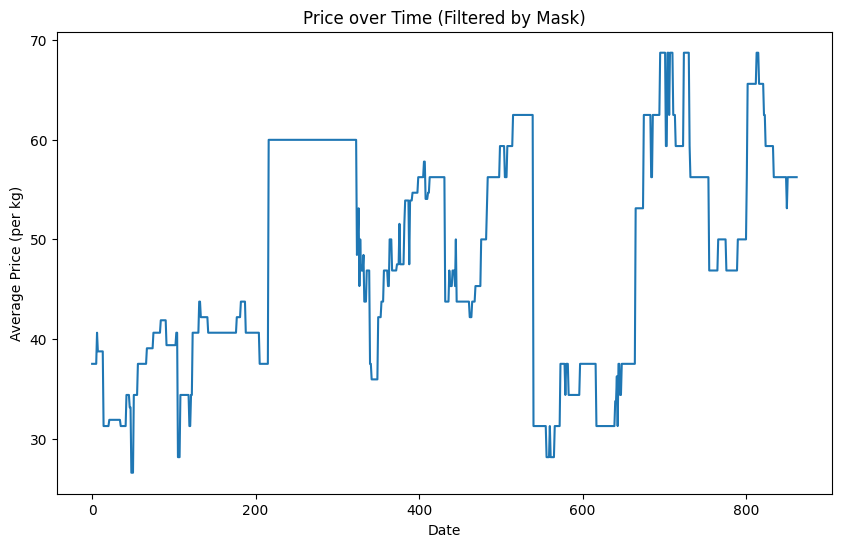

In [235]:
# Visualize the filtered data
plt.figure(figsize=(10,6))
plt.plot(available_data['y'])
plt.title('Price over Time (Filtered by Mask)')
plt.xlabel('Date')
plt.ylabel('Average Price (per kg)')
plt.show()

In [236]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

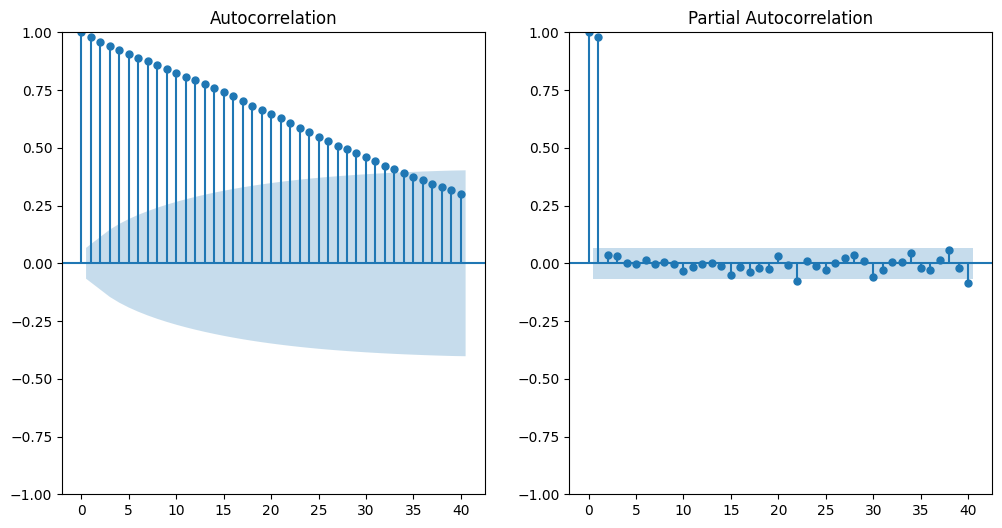

In [237]:
# Plot ACF and PACF for the given time series
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(available_data['y'], lags=40, ax=plt.gca())

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(available_data['y'], lags=40, ax=plt.gca())

plt.show()


In [238]:
# Define the range of parameters for grid search
p_values = range(0, 3)  # AR terms
d_values = range(0, 2)  # Differencing terms
q_values = range(0, 3)  # MA terms
P_values = range(0, 3)  # Seasonal AR terms
D_values = range(0, 2)  # Seasonal differencing terms
Q_values = range(0, 3)  # Seasonal MA terms
seasonal_periods = [12]  # Seasonal period (e.g., 12 for monthly data with yearly seasonality)

# Prepare parameter combinations
param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_periods))

# Initialize a list to store results
results = []

# Check if the dataset has missing values
if train_data['y'].isnull().sum() > 0:
    print("Warning: The dataset contains missing values. Consider imputing or removing them.")
else:
    print("No missing values detected in the data.")

# Loop through all parameter combinations
for param in param_grid:
    try:
        # Unpack the parameters
        p, d, q, P, D, Q, S = param

        # Define and fit the SARIMA model with the current parameters
        sarima_model = SARIMAX(train_data['y'],
                               order=(p, d, q),             # (p, d, q)
                               seasonal_order=(P, D, Q, S),  # (P, D, Q, S)
                               enforce_stationarity=False,   # Avoid stationarity constraint for SARIMA
                               enforce_invertibility=False)  # Avoid invertibility constraint for SARIMA
        
        # Fit the model
        sarima_results = sarima_model.fit(disp=False)

        # Store the model parameters and AIC
        results.append((param, sarima_results.aic))
        print(f"Successfully fitted model with parameters {param}. AIC: {sarima_results.aic}")

    except Exception as e:
        print(f"Error fitting model with parameters {param}: {e}")
        continue

# Check if any results were generated
if results:
    # Convert the results into a DataFrame
    results_df = pd.DataFrame(results, columns=["Params", "AIC"])

    # Sort by AIC and display the best parameters
    best_params = results_df.sort_values(by="AIC").iloc[0]
    print("\nBest Parameters:", best_params)
else:
    print("No valid SARIMA models were successfully fitted. Please review your data and parameter ranges.")


No missing values detected in the data.
Successfully fitted model with parameters (0, 0, 0, 0, 0, 0, 12). AIC: 6807.767432097133
Successfully fitted model with parameters (0, 0, 0, 0, 0, 1, 12). AIC: 5936.975979035321
Successfully fitted model with parameters (0, 0, 0, 0, 0, 2, 12). AIC: 5335.00127541545
Successfully fitted model with parameters (0, 0, 0, 0, 1, 0, 12). AIC: 4258.605783852309
Successfully fitted model with parameters (0, 0, 0, 0, 1, 1, 12). AIC: 4180.669195185842
Successfully fitted model with parameters (0, 0, 0, 0, 1, 2, 12). AIC: 4099.584924328799
Successfully fitted model with parameters (0, 0, 0, 1, 0, 0, 12). AIC: 4261.896965921636
Successfully fitted model with parameters (0, 0, 0, 1, 0, 1, 12). AIC: 4258.019351739549
Successfully fitted model with parameters (0, 0, 0, 1, 0, 2, 12). AIC: 4169.525602958023
Successfully fitted model with parameters (0, 0, 0, 1, 1, 0, 12). AIC: 4187.3721565044325
Successfully fitted model with parameters (0, 0, 0, 1, 1, 1, 12). AIC:

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 1, 2, 0, 1, 12). AIC: 3688.9563894848743


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 1, 2, 0, 2, 12). AIC: 3692.9529403335264
Successfully fitted model with parameters (0, 0, 1, 2, 1, 0, 12). AIC: 3619.0085481591327
Successfully fitted model with parameters (0, 0, 1, 2, 1, 1, 12). AIC: 3598.6813763951313
Successfully fitted model with parameters (0, 0, 1, 2, 1, 2, 12). AIC: 3588.3244718760725
Successfully fitted model with parameters (0, 0, 2, 0, 0, 0, 12). AIC: 5266.632466192314
Successfully fitted model with parameters (0, 0, 2, 0, 0, 1, 12). AIC: 4663.903787667356
Successfully fitted model with parameters (0, 0, 2, 0, 0, 2, 12). AIC: 4269.4177990920725
Successfully fitted model with parameters (0, 0, 2, 0, 1, 0, 12). AIC: 3521.4317217454227
Successfully fitted model with parameters (0, 0, 2, 0, 1, 1, 12). AIC: 3407.5661488334313
Successfully fitted model with parameters (0, 0, 2, 0, 1, 2, 12). AIC: 3342.325903145207
Successfully fitted model with parameters (0, 0, 2, 1, 0, 0, 12). AIC: 3533.8501965735877


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 2, 1, 0, 1, 12). AIC: 3810.310914201941


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 2, 1, 0, 2, 12). AIC: 3423.9612938090527
Successfully fitted model with parameters (0, 0, 2, 1, 1, 0, 12). AIC: 3437.61466946788
Successfully fitted model with parameters (0, 0, 2, 1, 1, 1, 12). AIC: 3393.087338085775
Successfully fitted model with parameters (0, 0, 2, 1, 1, 2, 12). AIC: 3337.2957324425843
Successfully fitted model with parameters (0, 0, 2, 2, 0, 0, 12). AIC: 3435.5983651285283


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 2, 2, 0, 1, 12). AIC: 3421.993991644521


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 2, 2, 0, 2, 12). AIC: 3403.8829554539643
Successfully fitted model with parameters (0, 0, 2, 2, 1, 0, 12). AIC: 3375.271281603743
Successfully fitted model with parameters (0, 0, 2, 2, 1, 1, 12). AIC: 3349.510596810576
Successfully fitted model with parameters (0, 0, 2, 2, 1, 2, 12). AIC: 3335.9157639568375
Successfully fitted model with parameters (0, 1, 0, 0, 0, 0, 12). AIC: 2860.5839169009764
Successfully fitted model with parameters (0, 1, 0, 0, 0, 1, 12). AIC: 2817.4030723184937
Successfully fitted model with parameters (0, 1, 0, 0, 0, 2, 12). AIC: 2766.594918334805
Successfully fitted model with parameters (0, 1, 0, 0, 1, 0, 12). AIC: 3277.083014587563
Successfully fitted model with parameters (0, 1, 0, 0, 1, 1, 12). AIC: 2803.6133401571165
Successfully fitted model with parameters (0, 1, 0, 0, 1, 2, 12). AIC: 2760.0520581332353
Successfully fitted model with parameters (0, 1, 0, 1, 0, 0, 12). AIC: 2820.8108712816284
Successfully f

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 1, 2, 0, 2, 12). AIC: 2770.6164697447584
Successfully fitted model with parameters (1, 0, 1, 2, 1, 0, 12). AIC: 2895.1071457588123
Successfully fitted model with parameters (1, 0, 1, 2, 1, 1, 12). AIC: 2760.694301572831
Successfully fitted model with parameters (1, 0, 1, 2, 1, 2, 12). AIC: 2756.6420638223035
Successfully fitted model with parameters (1, 0, 2, 0, 0, 0, 12). AIC: 2858.8646612425127
Successfully fitted model with parameters (1, 0, 2, 0, 0, 1, 12). AIC: 2804.4502779564746
Successfully fitted model with parameters (1, 0, 2, 0, 0, 2, 12). AIC: 2765.1939884596695
Successfully fitted model with parameters (1, 0, 2, 0, 1, 0, 12). AIC: 3237.55238432412
Successfully fitted model with parameters (1, 0, 2, 0, 1, 1, 12). AIC: 2797.4512743076884
Successfully fitted model with parameters (1, 0, 2, 0, 1, 2, 12). AIC: 2748.0891087219375
Successfully fitted model with parameters (1, 0, 2, 1, 0, 0, 12). AIC: 2822.7462081601843
Successfully 

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 2, 2, 0, 2, 12). AIC: 2769.3813465352496
Successfully fitted model with parameters (1, 0, 2, 2, 1, 0, 12). AIC: 2896.9256909789124
Successfully fitted model with parameters (1, 0, 2, 2, 1, 1, 12). AIC: 2762.6343200606825
Successfully fitted model with parameters (1, 0, 2, 2, 1, 2, 12). AIC: 2750.8134385322974
Successfully fitted model with parameters (1, 1, 0, 0, 0, 0, 12). AIC: 2858.683276332892
Successfully fitted model with parameters (1, 1, 0, 0, 0, 1, 12). AIC: 2815.7146272756654
Successfully fitted model with parameters (1, 1, 0, 0, 0, 2, 12). AIC: 2764.8821628855812
Successfully fitted model with parameters (1, 1, 0, 0, 1, 0, 12). AIC: 3275.926949020325
Successfully fitted model with parameters (1, 1, 0, 0, 1, 1, 12). AIC: 2802.5197381341777
Successfully fitted model with parameters (1, 1, 0, 0, 1, 2, 12). AIC: 2758.759733885752
Successfully fitted model with parameters (1, 1, 0, 1, 0, 0, 12). AIC: 2815.692840559318
Successfully f

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 1, 0, 1, 12). AIC: 2819.0820690934916
Successfully fitted model with parameters (2, 0, 1, 1, 0, 2, 12). AIC: 2770.611011398132
Successfully fitted model with parameters (2, 0, 1, 1, 1, 0, 12). AIC: 2998.443681893304
Successfully fitted model with parameters (2, 0, 1, 1, 1, 1, 12). AIC: 2811.19969909272
Successfully fitted model with parameters (2, 0, 1, 1, 1, 2, 12). AIC: 2758.7544287099213
Successfully fitted model with parameters (2, 0, 1, 2, 0, 0, 12). AIC: 2768.609079363312


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 2, 0, 1, 12). AIC: 2770.645658851393


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 2, 0, 2, 12). AIC: 2775.0659534768756
Successfully fitted model with parameters (2, 0, 1, 2, 1, 0, 12). AIC: 2891.850544338836
Successfully fitted model with parameters (2, 0, 1, 2, 1, 1, 12). AIC: 2757.849084119189
Successfully fitted model with parameters (2, 0, 1, 2, 1, 2, 12). AIC: 2758.5683145061867
Successfully fitted model with parameters (2, 0, 2, 0, 0, 0, 12). AIC: 2861.1561230369266


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 0, 0, 1, 12). AIC: 2810.898287354302
Successfully fitted model with parameters (2, 0, 2, 0, 0, 2, 12). AIC: 2767.5661635778874
Successfully fitted model with parameters (2, 0, 2, 0, 1, 0, 12). AIC: 3239.511805942173
Successfully fitted model with parameters (2, 0, 2, 0, 1, 1, 12). AIC: 2799.4978928592254
Successfully fitted model with parameters (2, 0, 2, 0, 1, 2, 12). AIC: 2749.8287607646084
Successfully fitted model with parameters (2, 0, 2, 1, 0, 0, 12). AIC: 2818.3450055810345


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 1, 0, 1, 12). AIC: 2811.960846330479


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 1, 0, 2, 12). AIC: 2772.01297326426
Successfully fitted model with parameters (2, 0, 2, 1, 1, 0, 12). AIC: 3006.2766827326845
Successfully fitted model with parameters (2, 0, 2, 1, 1, 1, 12). AIC: 2801.4953195155367
Successfully fitted model with parameters (2, 0, 2, 1, 1, 2, 12). AIC: 2750.528979370666


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 2, 0, 0, 12). AIC: 2770.9804662800093


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 2, 0, 1, 12). AIC: 2778.152783167165


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 2, 0, 2, 12). AIC: 2775.246088478322
Successfully fitted model with parameters (2, 0, 2, 2, 1, 0, 12). AIC: 2895.2052878421273


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 2, 1, 1, 12). AIC: 2758.593818693397


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 2, 1, 2, 12). AIC: 2752.5298936689287
Successfully fitted model with parameters (2, 1, 0, 0, 0, 0, 12). AIC: 2857.2460892051577
Successfully fitted model with parameters (2, 1, 0, 0, 0, 1, 12). AIC: 2817.70544749987
Successfully fitted model with parameters (2, 1, 0, 0, 0, 2, 12). AIC: 2766.874858968449
Successfully fitted model with parameters (2, 1, 0, 0, 1, 0, 12). AIC: 3268.040279755828
Successfully fitted model with parameters (2, 1, 0, 0, 1, 1, 12). AIC: 2804.5157263594438
Successfully fitted model with parameters (2, 1, 0, 0, 1, 2, 12). AIC: 2760.7593596185916
Successfully fitted model with parameters (2, 1, 0, 1, 0, 0, 12). AIC: 2802.7383534402616
Successfully fitted model with parameters (2, 1, 0, 1, 0, 1, 12). AIC: 2804.736216272154
Successfully fitted model with parameters (2, 1, 0, 1, 0, 2, 12). AIC: 2768.8607450157274
Successfully fitted model with parameters (2, 1, 0, 1, 1, 0, 12). AIC: 3015.340459643917
Successfully fit

In [239]:
#######################################
# SARIMA Model
#######################################
sarima_model = SARIMAX(train_data['y'], 
                       order=(0, 1, 2),
                       seasonal_order=(0, 1, 2, 12))
sarima_results = sarima_model.fit(disp=False)

sarima_forecast = sarima_results.get_forecast(steps=len(test_data))
sarima_pred = sarima_forecast.predicted_mean


In [240]:
sarima_pred

648    32.923443
649    32.995742
650    33.062018
651    33.044281
652    33.180160
         ...    
858    23.350580
859    22.995808
860    23.579475
861    23.840137
862    23.758030
Name: predicted_mean, Length: 215, dtype: float64

In [374]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for Random Forest predictions
rf_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'], sarima_pred)
rf_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'], sarima_pred)

print(f"Random Forest - Mean Squared Error (MSE): {rf_mse}")
print(f"Random Forest - Mean Absolute Error (MAE): {rf_mae}")


Random Forest - Mean Squared Error (MSE): 858.0709575590873
Random Forest - Mean Absolute Error (MAE): 27.74964806573853


In [264]:
from prophet import Prophet
#######################################
# Prophet Model
#######################################
prophet_model = Prophet()
prophet_model.fit(train_data[['ds', 'y']].rename(columns={'ds': 'ds', 'y': 'y'}))

future = prophet_model.make_future_dataframe(periods=len(test_data))
prophet_forecast = prophet_model.predict(future)
prophet_pred = prophet_forecast['yhat'][-len(test_data):]

19:15:02 - cmdstanpy - INFO - Chain [1] start processing
19:15:02 - cmdstanpy - INFO - Chain [1] done processing


In [265]:
prophet_pred

648    32.783466
649    32.714582
650    32.689149
651    32.378599
652    32.032686
         ...    
858    23.604615
859    25.605401
860    27.546921
861    29.058458
862    30.351445
Name: yhat, Length: 215, dtype: float64

In [372]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for Random Forest predictions
rf_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'], prophet_pred)
rf_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'], prophet_pred)

print(f"Random Forest - Mean Squared Error (MSE): {rf_mse}")
print(f"Random Forest - Mean Absolute Error (MAE): {rf_mae}")


Random Forest - Mean Squared Error (MSE): 1091.14479599372
Random Forest - Mean Absolute Error (MAE): 30.818303751777293


In [279]:
# Split the data FIRST
train_data = data[data['ds'] < '2023-01-01']
test_data = data[data['ds'] >= '2023-01-01']

# Generate lagged features for train and test sets separately
max_lag = 60

def create_lagged_features(data, max_lag):
    for lag in range(1, max_lag + 1):
        data[f'y_lag{lag}'] = data['y'].shift(lag)
    return data.dropna()

train_data = create_lagged_features(train_data, max_lag)
test_data = create_lagged_features(test_data, max_lag)

# Split training set further into training and validation subsets
train_subset = train_data[train_data['ds'] < '2022-07-01']
val_subset = train_data[train_data['ds'] >= '2022-07-01']

# Define features
features = [f'y_lag{i}' for i in range(1, max_lag + 1)]

# Find the optimal number of lags using validation data
best_lags = 0
best_mse = float('inf')

for num_lags in range(1, max_lag + 1):
    lag_features = features[:num_lags]
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Train on the training subset
    rf_model.fit(train_subset[lag_features], train_subset['y'])
    
    # Validate on the validation subset
    val_predictions = rf_model.predict(val_subset[lag_features])
    mse = mean_squared_error(val_subset['y'], val_predictions)
    
    if mse < best_mse:
        best_mse = mse
        best_lags = num_lags

print(f"Best number of lags: {best_lags} with MSE: {best_mse}")

C:\Windows\Temp\ipykernel_22248\74529997.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'y_lag{lag}'] = data['y'].shift(lag)


Best number of lags: 19 with MSE: 6.740409170830829


In [280]:
# Train final model with best lags on the full training set
final_features = features[:best_lags]
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_data[final_features], train_data['y'])

RandomForestRegressor(random_state=42)

In [281]:

# Predict and handle decimal predictions
rf_pred = rf_model.predict(test_data[final_features])

In [284]:
rf_pred_aligned = rf_pred[test_data['Mask'] == 1]

In [287]:
rf_pred_aligned

array([ 0.1785239 , 37.09375   , 37.3125    , 37.609375  , 37.671875  ,
       37.671875  , 37.1875    , 37.625     , 37.796875  , 37.734375  ,
       37.59375   , 37.671875  , 37.75      , 37.75      , 37.890625  ,
       38.109375  , 38.03645833, 37.56770833, 49.659375  , 50.38125   ,
       49.64375   , 49.6046875 , 49.5859375 , 50.29375   , 52.665625  ,
       53.6953125 , 53.8203125 , 54.2328125 , 61.690625  , 62.38125   ,
       62.40625   , 62.46875   , 62.475     , 62.475     , 62.475     ,
       62.5       , 62.5       , 56.565625  , 57.21875   , 61.85797942,
       62.41222826, 62.18722826, 62.25      , 62.25      , 61.93854167,
       60.55634921, 53.56485702,  0.        , 52.24491334, 53.83455919,
       53.63664084, 53.57414084, 53.89180877, 55.23350781, 61.93854167,
       58.59679621, 52.52898221, 53.31972233, 53.56485702, 53.58455919,
       53.85535044, 53.61463426, 53.53985702, 53.82631535, 54.94704948,
       60.58134921, 53.56485702, 52.80711653, 52.83280019, 52.85

In [371]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for Random Forest predictions
rf_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'], rf_pred_aligned)
rf_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'], rf_pred_aligned)

print(f"Random Forest - Mean Squared Error (MSE): {rf_mse}")
print(f"Random Forest - Mean Absolute Error (MAE): {rf_mae}")


Random Forest - Mean Squared Error (MSE): 252.76389726019204
Random Forest - Mean Absolute Error (MAE): 10.004492945418328


In [357]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Split the data FIRST
train_data = data[data['ds'] < '2023-01-01']
test_data = data[data['ds'] >= '2023-01-01']

# Generate lagged features for train and test sets separately
max_lag = 60

def create_lagged_features(data, max_lag):
    for lag in range(1, max_lag + 1):
        data[f'y_lag{lag}'] = data['y'].shift(lag)
    return data.dropna()

train_data = create_lagged_features(train_data, max_lag)
test_data = create_lagged_features(test_data, max_lag)

# Split training set further into training and validation subsets
train_subset = train_data[train_data['ds'] < '2022-07-01']
val_subset = train_data[train_data['ds'] >= '2022-07-01']

# Define features
features = [f'y_lag{i}' for i in range(1, max_lag + 1)]


C:\Windows\Temp\ipykernel_22248\2936903023.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'y_lag{lag}'] = data['y'].shift(lag)


In [358]:
# Find the optimal number of lags using validation data for XGBoost
best_lags = 0
best_mse = float('inf')

for num_lags in range(1, max_lag + 1):
    lag_features = features[:num_lags]
    
    # Initialize the XGBoost model
    xgb_model = XGBRegressor(n_estimators=100, random_state=42)
    
    # Train the model on the training subset
    xgb_model.fit(train_subset[lag_features], train_subset['y'])
    
    # Validate on the validation subset
    val_predictions = xgb_model.predict(val_subset[lag_features])
    mse = mean_squared_error(val_subset['y'], val_predictions)
    
    if mse < best_mse:
        best_mse = mse
        best_lags = num_lags

print(f"Best number of lags for XGBoost: {best_lags} with MSE: {best_mse}")


Best number of lags for XGBoost: 52 with MSE: 7.1763918787893894


In [385]:
# Train final XGBoost model with best lags on the full training set
final_features = features[:best_lags]
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(train_data[final_features], train_data['y'])

# Predict and handle decimal predictions
xgb_pred = xgb_model.predict(test_data[final_features])
xgb_pred_aligned = xgb_pred[test_data['Mask'] == 1]

In [387]:
from sklearn.preprocessing import StandardScaler
# Create a scaler instance
scaler = StandardScaler()

# Train final XGBoost model with best lags on the full training set
final_features = features[:best_lags]

# Fit scaler on the training target and transform it
train_data['y_scaled'] = scaler.fit_transform(train_data[['y']])

# Initialize the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Fit the model on the scaled target
xgb_model.fit(train_data[final_features], train_data['y_scaled'])

# Predict on the test data
xgb_pred_scaled = xgb_model.predict(test_data[final_features])

# Reverse the scaling for the predictions
xgb_pred = scaler.inverse_transform(xgb_pred_scaled.reshape(-1, 1))

# Align predictions based on the 'Mask' column
xgb_pred_aligned = xgb_pred[test_data['Mask'] == 1]


In [388]:
xgb_pred_aligned

array([[ 0.21112233],
       [37.09897   ],
       [37.261707  ],
       [36.485004  ],
       [36.30317   ],
       [37.16686   ],
       [36.65167   ],
       [36.58814   ],
       [36.767433  ],
       [36.767433  ],
       [36.697353  ],
       [35.801346  ],
       [36.058582  ],
       [36.892395  ],
       [35.604176  ],
       [37.590214  ],
       [36.30837   ],
       [36.250237  ],
       [49.60735   ],
       [51.58032   ],
       [51.705406  ],
       [52.44434   ],
       [52.160927  ],
       [53.542725  ],
       [54.06344   ],
       [54.202553  ],
       [53.602364  ],
       [53.513237  ],
       [62.071323  ],
       [62.286797  ],
       [62.22028   ],
       [61.97114   ],
       [61.686752  ],
       [62.129524  ],
       [62.31152   ],
       [62.232132  ],
       [62.290302  ],
       [56.43897   ],
       [56.64439   ],
       [62.51609   ],
       [62.424442  ],
       [62.08203   ],
       [62.36223   ],
       [61.1432    ],
       [60.744366  ],
       [62

In [395]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Align the test data by excluding the first data point
aligned_test_data = test_data[test_data['Mask'] == 1].iloc[1:]  # Skip the first data point

# Calculate MSE and MAE for LSTM predictions
xgb_mse = mean_squared_error(aligned_test_data['y'], xgb_pred_aligned[1:])
xgb_mae = mean_absolute_error(aligned_test_data['y'], xgb_pred_aligned[1:])

print(f"LSTM - Mean Squared Error (MSE): {xgb_mse}")
print(f"LSTM - Mean Absolute Error (MAE): {xgb_mae}")

LSTM - Mean Squared Error (MSE): 1407.3544818676044
LSTM - Mean Absolute Error (MAE): 24.982575579224346


In [294]:
from sklearn.preprocessing import MinMaxScaler

# Define function to reverse scaling (to original range)
def reverse_scaling(predictions, data):
    return predictions * (data['y'].max() - data['y'].min()) + data['y'].min()

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Split the data into train and test (after defining 'Mask')
train_data = data[data['ds'] < '2023-01-01']
test_data = data[data['ds'] >= '2023-01-01']

# Apply MinMax scaling only on the training data
scaler = MinMaxScaler()
train_scaled = train_data[['y']]
train_scaled['y'] = scaler.fit_transform(train_scaled)

# Apply the same scaler to the test data (to avoid leakage)
test_scaled = test_data[['y']]
test_scaled['y'] = scaler.transform(test_scaled)

# Evaluate different sequence lengths (lags)
lags = [1, 2, 3, 5, 10, 15, 20, 30, 35, 40, 45, 50]  # List of lags to try
best_mse = float('inf')  # Initialize best MSE as a large number
best_seq_length = None
best_lstm_pred = None

for seq_length in lags:
    # Create sequences for both training and test data
    X_train, y_train = create_sequences(train_scaled['y'].values, seq_length)
    X_test, y_test = create_sequences(test_scaled['y'].values, seq_length)

    # Reshape input for LSTM: [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    lstm_model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')

    # Train the LSTM model
    lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Make predictions
    lstm_pred = lstm_model.predict(X_test)

    # Reverse scaling to get predictions back to original values
    lstm_pred = reverse_scaling(lstm_pred, data)

    # Calculate MSE for the current sequence length
    mse = mean_squared_error(y_test, lstm_pred)

    # Update best MSE and best sequence length
    if mse < best_mse:
        best_mse = mse
        best_seq_length = seq_length
        best_lstm_pred = lstm_pred

# Print the best sequence length and its MSE
print(f"Best Sequence Length (Lag): {best_seq_length}")
print(f"Best MSE: {best_mse}")

C:\Windows\Temp\ipykernel_22248\3374328753.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_scaled['y'] = scaler.fit_transform(train_scaled)
C:\Windows\Temp\ipykernel_22248\3374328753.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_scaled['y'] = scaler.transform(test_scaled)
c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Inpu

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best Sequence Length (Lag): 1
Best MSE: 1067.4771211082627


In [295]:
# Final model with the best sequence length
X_train, y_train = create_sequences(train_scaled['y'].values, best_seq_length)
X_test, y_test = create_sequences(test_scaled['y'].values, best_seq_length)

# Reshape input for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [296]:
# Define and compile the LSTM model
lstm_model = Sequential([
    LSTM(100, activation='relu', input_shape=(best_seq_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1641  
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0834
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0457
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0041    
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029    
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0041    
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039    
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039    
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025    
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058
Epoch 13/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037    
Epoch 14/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031    
Epoch 15/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

In [299]:
# Make predictions on the test data
lstm_pred = lstm_model.predict(X_test)
# Apply reverse scaling to get the predictions back to the original range
lstm_pred = reverse_scaling(lstm_pred, data)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [318]:
# Check the lengths of lstm_pred and test_data['Mask']
print(f"Length of lstm_pred: {len(lstm_pred)}")
print(f"Length of test_data['Mask']: {len(test_data['Mask'])}")

Length of lstm_pred: 730
Length of test_data['Mask']: 731


In [320]:
lstm_pred_aligned = lstm_pred[test_data['Mask'].iloc[:len(lstm_pred)] == 1]

In [407]:
lstm_pred_aligned.size

214

In [408]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Align the test data by excluding the first data point
aligned_test_data = test_data[test_data['Mask'] == 1].iloc[1:]  # Skip the first data point

# Calculate MSE and MAE for LSTM predictions
lstm_mse = mean_squared_error(aligned_test_data['y'], lstm_pred_aligned)
lstm_mae = mean_absolute_error(aligned_test_data['y'], lstm_pred_aligned)

print(f"LSTM - Mean Squared Error (MSE): {lstm_mse}")
print(f"LSTM - Mean Absolute Error (MAE): {lstm_mae}")


LSTM - Mean Squared Error (MSE): 33.677773011255226
LSTM - Mean Absolute Error (MAE): 5.4778634370348165


In [344]:
# Updated Transformer Model with Optimal Features and Mask Handling
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, mask):
        self.X = X
        self.y = y
        self.mask = mask

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.mask[idx]

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers):
        super(TransformerModel, self).__init__()
        
        # Linear layer to increase input dimension to the desired embedding dimension
        self.input_fc = nn.Linear(input_dim, embed_dim)
        
        # Transformer encoder
        self.encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, ff_dim)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers)
        
        # Final fully connected layer
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        # Apply the linear transformation to match embed_dim
        x = self.input_fc(x)
        
        # Pass through transformer
        x = self.transformer(x)
        
        # Output layer
        return self.fc(x.mean(dim=1))  # Use mean of output sequence for prediction

# Ensure input_dim (1) is passed correctly when creating the model
transformer = TransformerModel(input_dim=1, embed_dim=16, num_heads=2, ff_dim=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

# Dataset and DataLoader setup with Mask
train_dataset = TimeSeriesDataset(torch.tensor(X_train, dtype=torch.float32),
                                   torch.tensor(y_train, dtype=torch.float32),
                                   torch.tensor(train_data['Mask'].values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop with mask handling
for epoch in range(50):
    for batch_X, batch_y, batch_mask in train_loader:
        optimizer.zero_grad()
        outputs = transformer(batch_X)  # Input is already in 3D shape (batch_size, seq_length, input_dim)
        
        # Apply mask to align only valid predictions
        outputs = outputs.squeeze()  # Remove extra dimension
        masked_outputs = outputs * batch_mask  # Mask out invalid predictions
        masked_y = batch_y * batch_mask  # Mask out invalid targets
        
        loss = criterion(masked_outputs, masked_y)
        loss.backward()
        optimizer.step()

In [ ]:
# After training, evaluate on test data with mask alignment
transformer.eval()
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # No need to unsqueeze if X_test is 3D already
transformer_pred = transformer(x_test_tensor).detach().numpy()

# Reverse scaling for Transformer predictions
transformer_pred = reverse_scaling(transformer_pred, data)

In [352]:
transformer_pred_aligned = transformer_pred[test_data['Mask'].iloc[:len(transformer_pred)] == 1]

In [404]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Align the test data by excluding the first data point
aligned_test_data = test_data[test_data['Mask'] == 1].iloc[1:]  # Skip the first data point

# Calculate MSE and MAE for LSTM predictions
transformer_mse = mean_squared_error(aligned_test_data['y'], transformer_pred_aligned)
transformer_mae = mean_absolute_error(aligned_test_data['y'], transformer_pred_aligned)

print(f"LSTM - Mean Squared Error (MSE): {lstm_mse}")
print(f"LSTM - Mean Absolute Error (MAE): {lstm_mae}")


LSTM - Mean Squared Error (MSE): 32.3309923802884
LSTM - Mean Absolute Error (MAE): 5.343439680672137


In [409]:
# Create a comparison DataFrame
model_comparison = pd.DataFrame({
    'Model': ['SARIMA', 'Prophet', 'Random Forest', 'XGBoost', 'LSTM', 'Transformer'],
    'MSE': [sarima_mse, prophet_mse, rf_mse, xgb_mse, lstm_mse, transformer_mse],
    'MAE': [sarima_mae, prophet_mae, rf_mae, xgb_mae, lstm_mae, transformer_mae]
})

# Sort models by MSE and MAE
model_comparison_sorted = model_comparison.sort_values(by='MSE')

print(model_comparison_sorted)

           Model          MSE        MAE
5    Transformer    32.330992   5.343440
4           LSTM    33.677773   5.477863
2  Random Forest   252.763897  10.004493
0         SARIMA   858.070958  27.749648
1        Prophet  1091.144796  30.818304
3        XGBoost  1407.354482  24.982576


C:\Windows\Temp\ipykernel_22248\809461196.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_comparison_sorted, x='Model', y='MSE', palette='viridis')


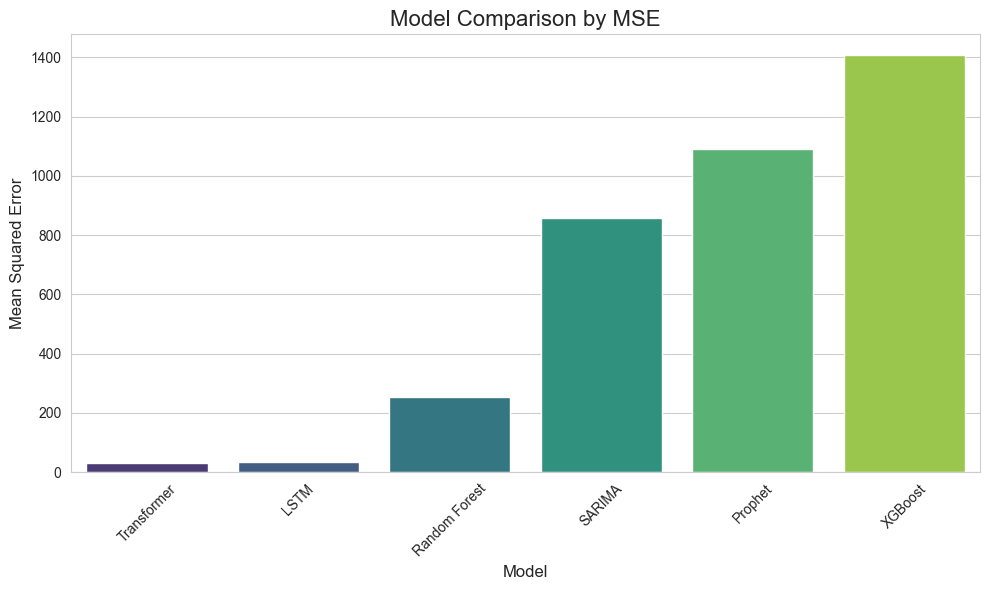

C:\Windows\Temp\ipykernel_22248\809461196.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_comparison_sorted, x='Model', y='MAE', palette='coolwarm')


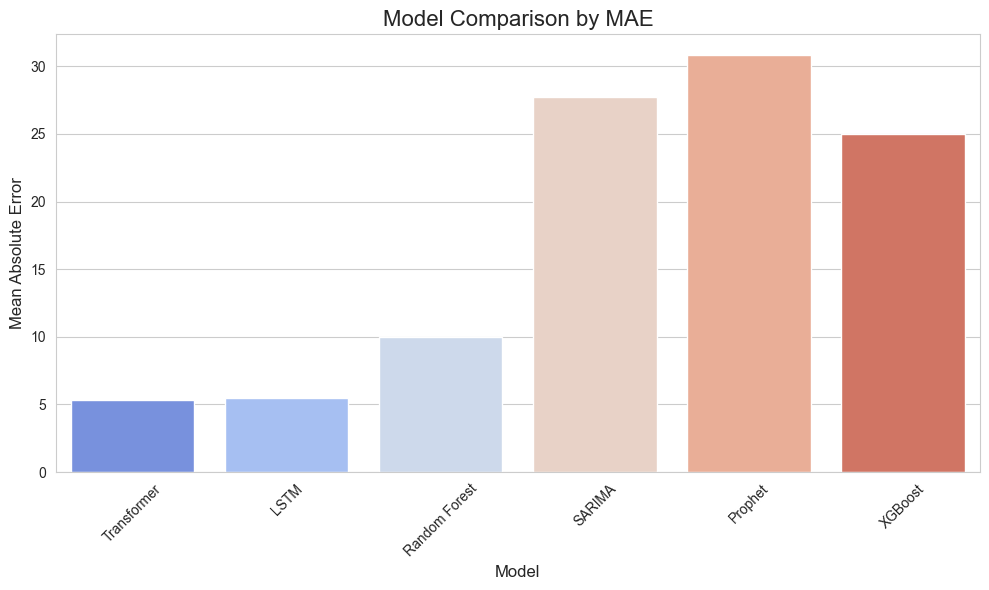

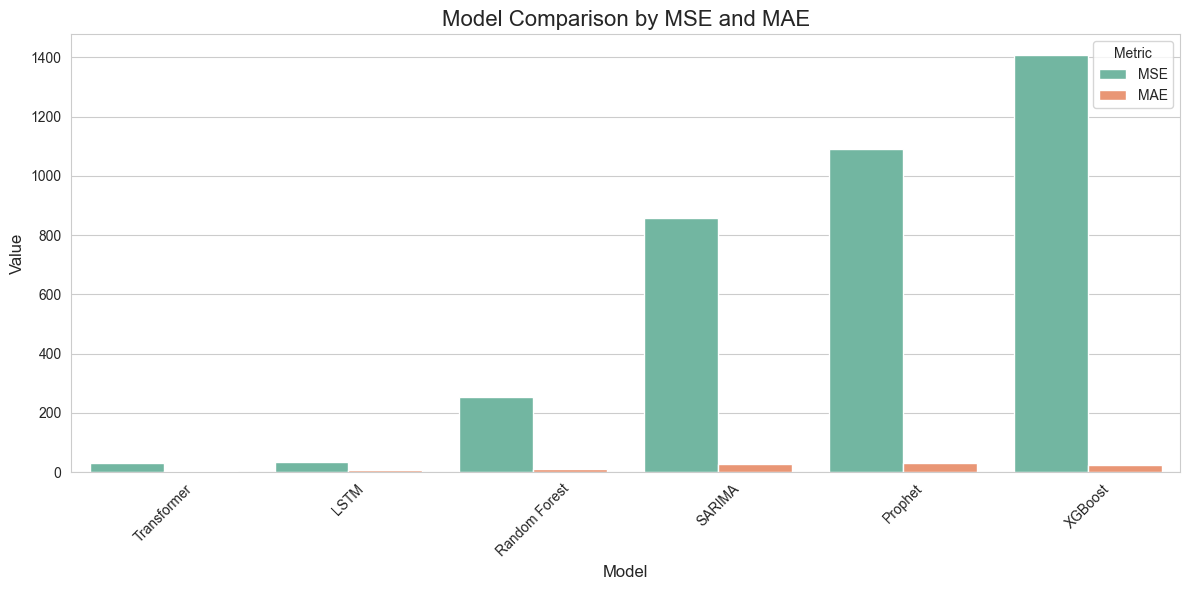

In [410]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style('whitegrid')

# Plot MSE for each model
plt.figure(figsize=(10, 6))
sns.barplot(data=model_comparison_sorted, x='Model', y='MSE', palette='viridis')
plt.title('Model Comparison by MSE', fontsize=16)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MAE for each model
plt.figure(figsize=(10, 6))
sns.barplot(data=model_comparison_sorted, x='Model', y='MAE', palette='coolwarm')
plt.title('Model Comparison by MAE', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MSE and MAE together as a grouped bar plot
melted_comparison = model_comparison_sorted.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_comparison, x='Model', y='Value', hue='Metric', palette='Set2')
plt.title('Model Comparison by MSE and MAE', fontsize=16)
plt.ylabel('Value', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(title='Metric', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


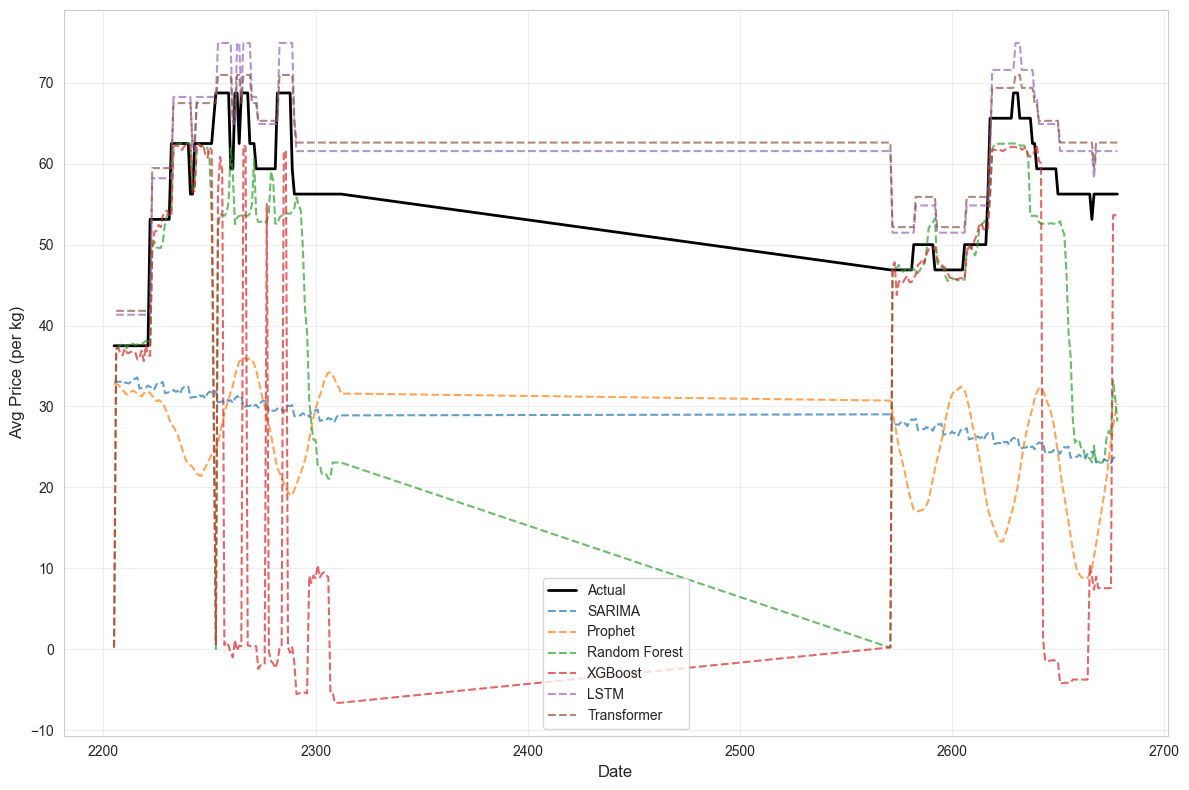

In [415]:
import matplotlib.pyplot as plt

# Actual test values for Mask=1
actual_values = test_data['y'][test_data['Mask'] == 1]

# Plot predictions for each model
plt.figure(figsize=(12, 8))

plt.plot(actual_values.index, actual_values, label='Actual', color='black', linewidth=2)

# Add model predictions
plt.plot(actual_values.index, sarima_pred, label='SARIMA', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, prophet_pred, label='Prophet', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, rf_pred_aligned, label='Random Forest', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, xgb_pred_aligned, label='XGBoost', linestyle='--', alpha=0.7)
plt.plot(actual_values.index[1:], lstm_pred_aligned, label='LSTM', linestyle='--', alpha=0.7)
plt.plot(actual_values.index[1:], transformer_pred_aligned, label='Transformer', linestyle='--', alpha=0.7)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Avg Price (per kg)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()
